In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df= pd.read_excel('FAOSTAT_data.xlsx')


In [5]:
df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2019,2019,ha,29203.0,A,Official figure,NaN
1,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2019,2019,kg/ha,1308.3,A,Official figure,NaN
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1371,"Almonds, in shell",2019,2019,t,38205.0,A,Official figure,NaN
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2020,2020,ha,22134.0,A,Official figure,NaN
4,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2020,2020,kg/ha,1775.9,A,Official figure,NaN


In [6]:
df.isnull().sum()

Domain Code              0
Domain                   0
Area Code (M49)          0
Area                     0
Element Code             0
Element                  0
Item Code (CPC)          5
Item                     0
Year Code                0
Year                     0
Unit                     2
Value                 6517
Flag                     4
Flag Description        13
Note                219549
dtype: int64

In [7]:

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder# Selecting columns to impute
cols_to_impute = ['Item Code (CPC)', 'Unit', 'Value', 'Flag', 'Flag Description']

#  Copy and prepare for encoding
df_encoded = df.copy()
label_encoders = {}

#  Encode categorical columns to numeric
for column in cols_to_impute:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df_encoded[column] = df[column].astype(str)  # Convert NaN to string for fitting
        df_encoded[column] = le.fit_transform(df_encoded[column])
        label_encoders[column] = le

#  Apply KNN imputation technique 
imputer = KNNImputer(n_neighbors=5)  #  tune n_neighbors
df_encoded[cols_to_impute] = imputer.fit_transform(df_encoded[cols_to_impute])

# Decode categorical columns back
for column in cols_to_impute:
    if column in label_encoders:
        df_encoded[column] = df_encoded[column].round().astype(int)
        df_encoded[column] = label_encoders[column].inverse_transform(df_encoded[column])


In [8]:
# Updating the original DataFrame with imputed columns
df[cols_to_impute] = df_encoded[cols_to_impute]


In [9]:
df.drop(columns=['Note'], inplace=True)


In [10]:
df.isnull().sum()

Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code (CPC)     0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64

In [11]:


# # Step 1: Filter only crop-relevant elements

    
crop_elements = ['Area harvested', 'Yield', 'Production']
df_crop = df[df['Element'].isin(crop_elements)]

# Step 2: Pivot the value column only (remove pivoting of unit)
df_pivot = df_crop.pivot_table(
    index=['Area', 'Year', 'Item'],
    columns='Element',
    values='Value',
    aggfunc='first'
).reset_index()


In [12]:
df_pivot.isnull().sum()

Element
Area                  0
Year                  0
Item                  0
Area harvested    35166
Production          172
Yield             34902
dtype: int64

In [13]:
df_pivot.head()

Element,Area,Year,Item,Area harvested,Production,Yield
0,Afghanistan,2019,"Almonds, in shell",29203.0,38205.00,1308.3
1,Afghanistan,2019,"Anise, badian, coriander, cumin, caraway, fenn...",25293.0,17807.76,704.1
2,Afghanistan,2019,Apples,27559.0,250324.00,9083.2
3,Afghanistan,2019,Apricots,17719.0,129363.00,7300.8
4,Afghanistan,2019,Barley,84070.0,123576.00,1469.9


In [14]:
from sklearn.impute import KNNImputer

# Columns to impute after pivoting
col_to_impute = ['Area harvested', 'Production', 'Yield']

# Apply KNN imputation on the pivoted DataFrame
imputer = KNNImputer(n_neighbors=5)
df_pivot[col_to_impute] = imputer.fit_transform(df_pivot[col_to_impute])


In [15]:
df_pivot.isnull().sum()

Element
Area              0
Year              0
Item              0
Area harvested    0
Production        0
Yield             0
dtype: int64

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define input features and multiple target columns
X = df_pivot[['Year', 'Area', 'Item']]
y = df_pivot[['Area harvested', 'Production', 'Yield']]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing (encode categorical variables)
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Area', 'Item']),
    ('num', 'passthrough', ['Year'])
])

# Build pipeline with multi-output regression
regressor = MultiOutputRegressor(RandomForestRegressor(random_state=42))

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Train model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)


In [17]:
from sklearn.metrics import r2_score, mean_absolute_error

target_names = y.columns

for i, target in enumerate(target_names):
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"{target} — R²: {r2:.3f}, MAE: {mae:.2f}")


Area harvested — R²: 0.892, MAE: 863395.42
Production — R²: 0.958, MAE: 399333.09
Yield — R²: 0.812, MAE: 3712.62


In [18]:
import joblib
joblib.dump(pipeline, 'multioutput_crop_model.pkl')


['multioutput_crop_model.pkl']

In [19]:
df_pivot.to_csv("df_pivot.csv", index=False)


Crop Types: Study the distribution of the Item column to identify the most and least cultivated crops across regions.


Item
Hen eggs in shell, fresh                          4546
Meat of chickens, fresh or chilled                2906
Meat of cattle with the bone, fresh or chilled    2900
Other vegetables, fresh n.e.c.                    2821
Raw milk of cattle                                2805
                                                  ... 
Jojoba seeds                                        15
Other camelids                                      10
Other rodents                                       10
Kapok fibre, raw                                     8
Kapokseed in shell                                   8
Name: count, Length: 276, dtype: int64


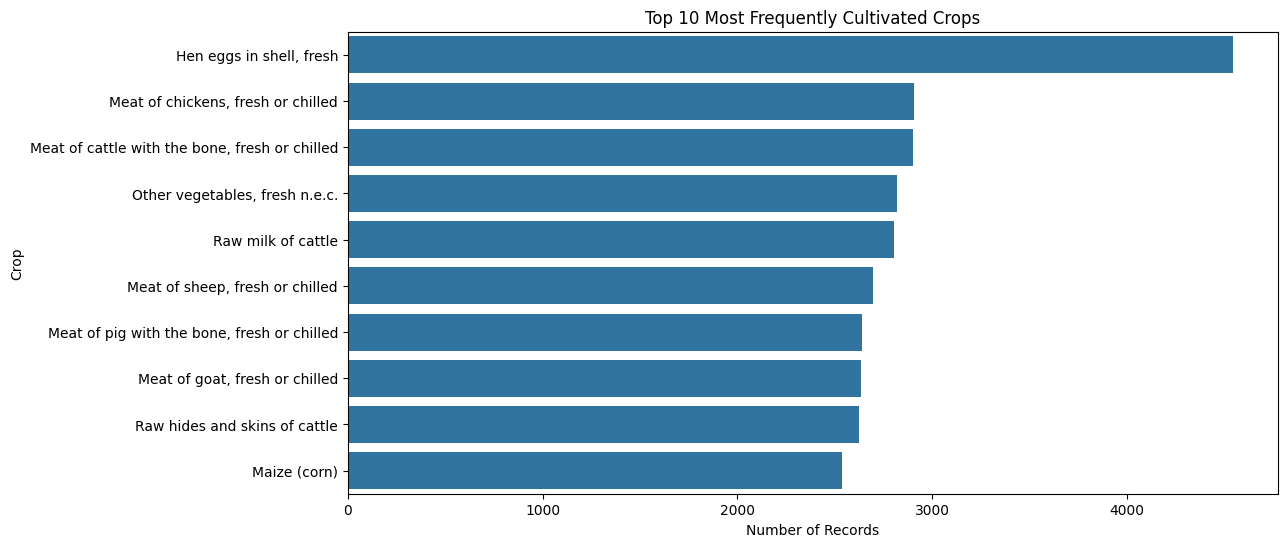

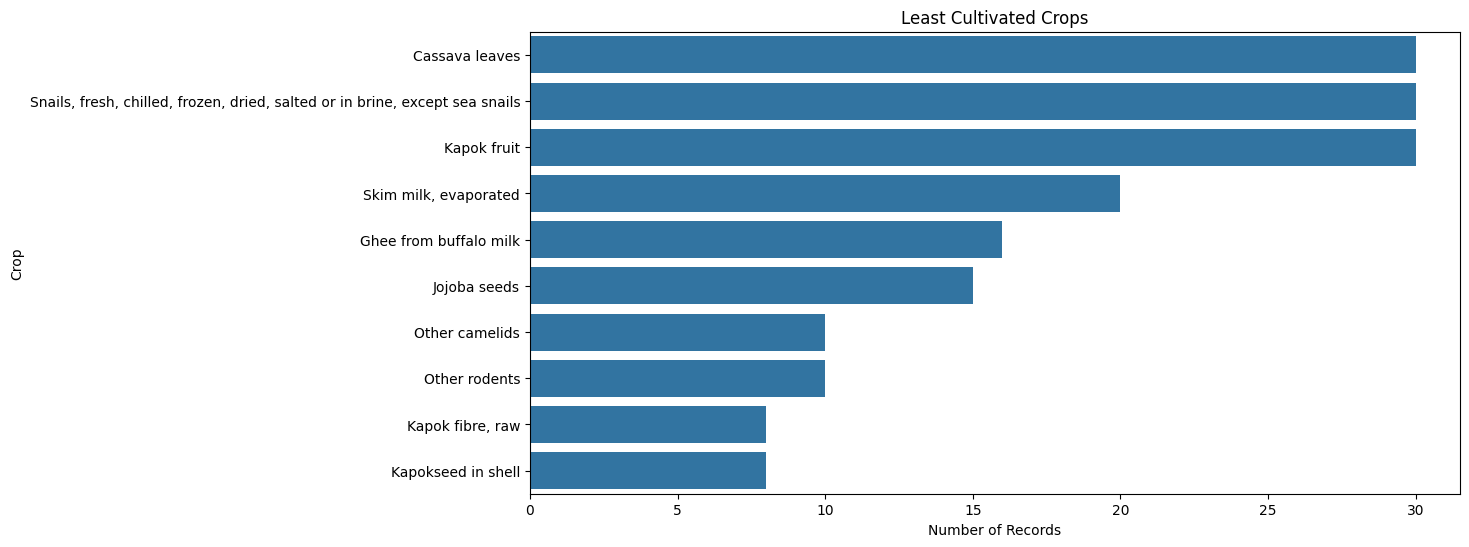

In [20]:
item_counts = df['Item'].value_counts()
print(item_counts)
plt.figure(figsize=(12, 6))
sns.barplot(x=item_counts.head(10).values, y=item_counts.head(10).index)
plt.title("Top 10 Most Frequently Cultivated Crops")
plt.xlabel("Number of Records")
plt.ylabel("Crop")
plt.show()

# Least cultivated crops
plt.figure(figsize=(12, 6))
sns.barplot(x=item_counts.tail(10).values, y=item_counts.tail(10).index)
plt.title("Least Cultivated Crops")
plt.xlabel("Number of Records")
plt.ylabel("Crop")
plt.show()

Geographical Distribution: Explore the Area column to understand which regions focus on specific crops or have high agricultural activity.


Area
China                         2640
China, mainland               2504
Mexico                        2181
T�rkiye                       2141
Morocco                       1970
United States of America      1943
Iran (Islamic Republic of)    1920
Peru                          1917
Egypt                         1806
Ukraine                       1798
Name: count, dtype: int64


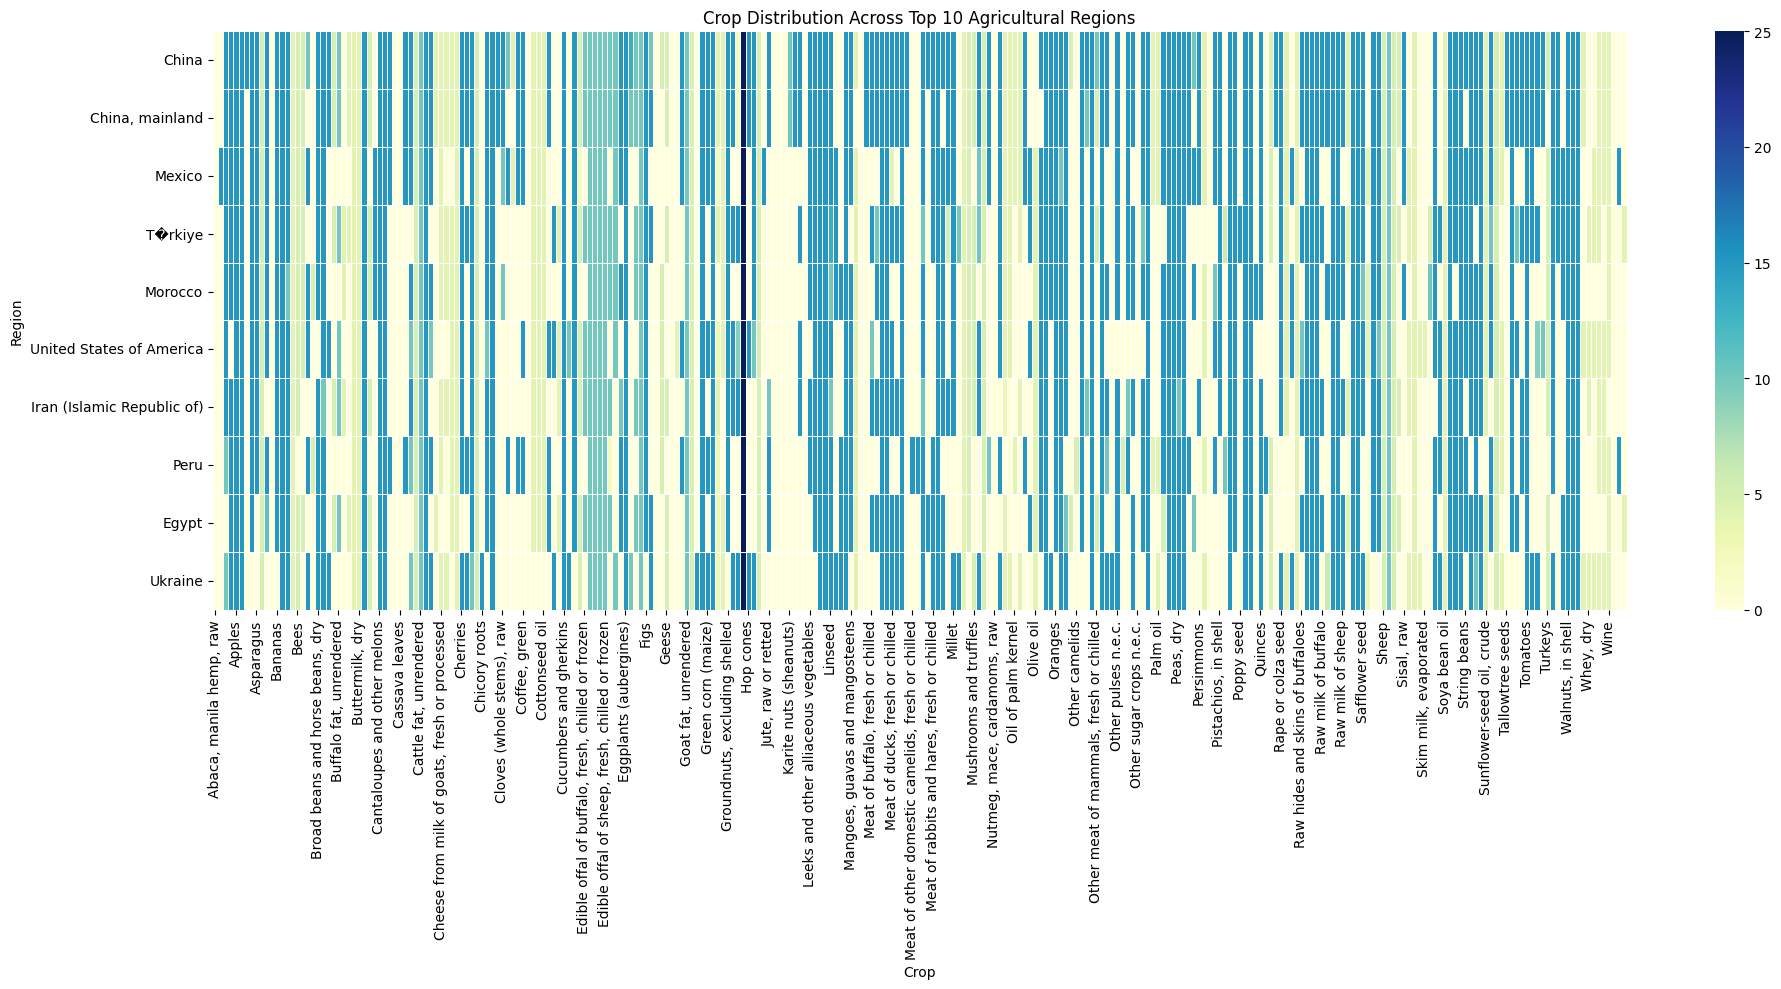

In [21]:
region_counts = df['Area'].value_counts()
print(region_counts.head(10))
import seaborn as sns
import matplotlib.pyplot as plt

# Create a crop-region frequency pivot table
pivot = df.pivot_table(index='Area', columns='Item', aggfunc='size', fill_value=0)

# Visualize top 10 regions with highest activity
top_regions = region_counts.head(10).index
plt.figure(figsize=(20, 10))
sns.heatmap(pivot.loc[top_regions], cmap='YlGnBu', linewidths=0.5)
plt.title("Crop Distribution Across Top 10 Agricultural Regions")
plt.ylabel("Region")
plt.xlabel("Crop")
plt.tight_layout()
plt.show()


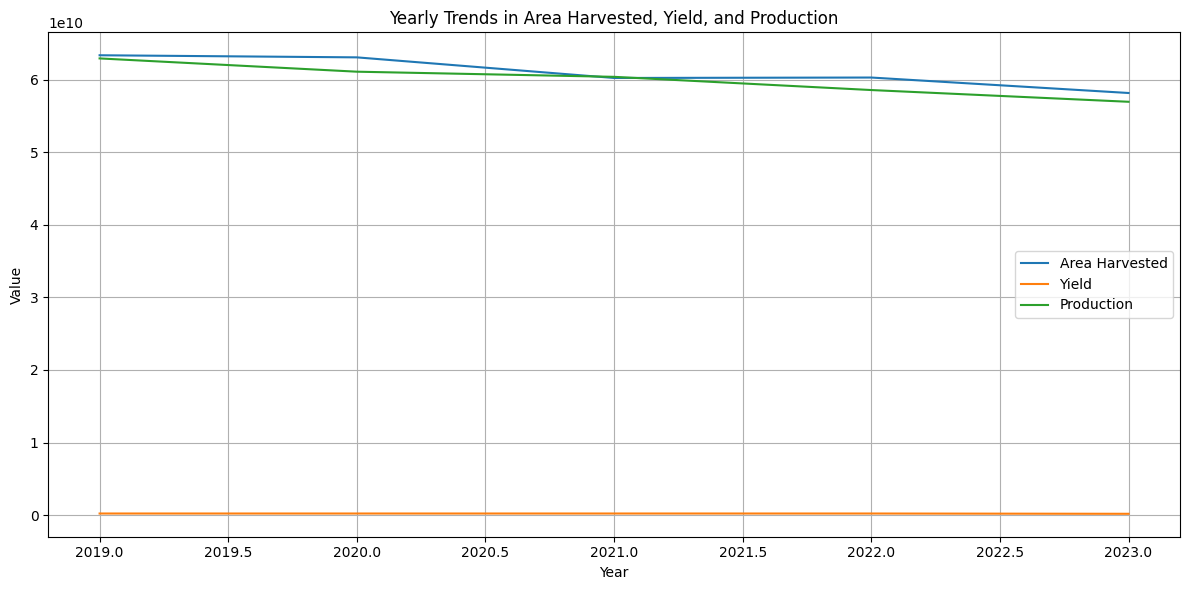

In [22]:


# Assuming your DataFrame is called df
yearly_trends = df_pivot.groupby('Year')[['Area harvested', 'Yield', 'Production']].sum().reset_index()


plt.figure(figsize=(12, 6))

plt.plot(yearly_trends['Year'], yearly_trends['Area harvested'], label='Area Harvested')
plt.plot(yearly_trends['Year'], yearly_trends['Yield'], label='Yield')
plt.plot(yearly_trends['Year'], yearly_trends['Production'], label='Production')

plt.title('Yearly Trends in Area Harvested, Yield, and Production')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd



# Drop rows with missing values in relevant columns
df_clean = df_pivot.dropna(subset=['Area', 'Item', 'Year', 'Area harvested', 'Yield'])

# Convert data types
df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')
df_clean['Area harvested'] = pd.to_numeric(df_clean['Area harvested'], errors='coerce')
df_clean['Yield'] = pd.to_numeric(df_clean['Yield'], errors='coerce')


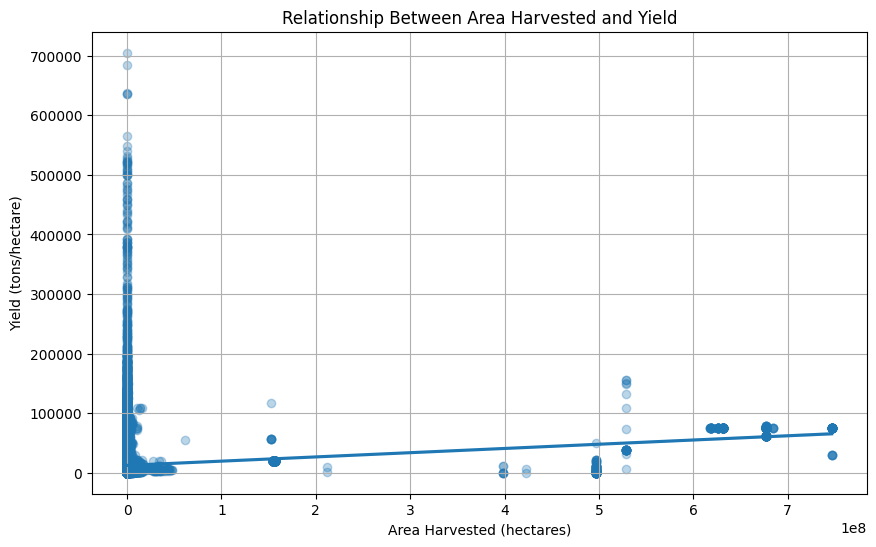

In [25]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df_clean, x='Area harvested', y='Yield', scatter_kws={'alpha':0.3})
plt.title("Relationship Between Area Harvested and Yield")
plt.xlabel("Area Harvested (hectares)")
plt.ylabel("Yield (tons/hectare)")
plt.grid(True)
plt.show()
